# 3. Neural Network from scratch

## Prerequisites

  - Install Conda and create environment: see notebook *1. Conda setup*
  - Install Poetry and create configuration: see notebook *2. Poetry setup*

Make sure you select the environment (kernel) *NN* to run this notebook. Also activate it in companion terminal:  
`conda activate NN`

Let's check we have Python 3.9 running:

In [1]:
!python --version

Python 3.9.7


Let's make sure packages and dependencies are installed by Poetry:  
```poetry install```

Let's check our packages and dependencies:

In [2]:
!poetry show --tree

matplotlib 3.5.1 Python plotting package
├── cycler >=0.10
├── fonttools >=4.22.0
├── kiwisolver >=1.0.1
├── numpy >=1.17
├── packaging >=20.0
│   └── pyparsing >=2.0.2,<3.0.5 || >3.0.5 
├── pillow >=6.2.0
├── pyparsing >=2.2.1
├── python-dateutil >=2.7
│   └── six >=1.5 
└── setuptools-scm >=4
    ├── packaging >=20.0 
    │   └── pyparsing >=2.0.2,<3.0.5 || >3.0.5 
    └── tomli >=1.0.0 
numpy 1.22.1 NumPy is the fundamental package for array computing with Python.
pytest 6.2.5 pytest: simple powerful testing with Python
├── atomicwrites >=1.0
├── attrs >=19.2.0
├── colorama *
├── iniconfig *
├── packaging *
│   └── pyparsing >=2.0.2,<3.0.5 || >3.0.5 
├── pluggy >=0.12,<2.0
├── py >=1.8.2
└── toml *
tensorflow 2.7.0 TensorFlow is an open source machine learning framework for everyone.
├── absl-py >=0.4.0
│   └── six * 
├── astunparse >=1.6.0
│   └── six >=1.6.1,<2.0 
├── flatbuffers >=1.12,<3.0
├── gast >=0.2.1,<0.5.0
├── google-pasta >=0.1.1
│   └── six * 
├── grpcio >=1.24.3,<2.0
│

If we want to update the Conda environment, we can run (in companion terminal):  
```
conda env update --prune -f environment_init.yml
```

If we want to update the Poetry setup, we can run (in companion terminal, making sure NN is activated):  
```
poetry update
```

We can create shortcuts for these actions in a separate **Makefile** (check its contents), which can then be called from a terminal:
```
make conda-udate
make poetry-update
```

## Linear model

Note: This notebook is inspired from https://fullstackdeeplearning.com/spring2021/notebook-1/.

### Generate and visualize data

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Let us create and show a dataset of 20 points:

In [4]:
nb_datapoints = 10
input_dim = 1
x = np.random.uniform(-1, 1, (nb_datapoints, input_dim))
x.sort(axis=0)

Suppose that we want to approximate the 'true' function \bar{f}(x) = x/2 + 1:


In [5]:
output_dim = 1

weights_true = np.random.uniform(-1, 1, (input_dim, output_dim))
bias_true = np.random.uniform(-1, 1, (output_dim,))

y_true = x @ weights_true + bias_true # Matrix multiplication and element-wise addition

Let's inspect all the shapes:

In [6]:
print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y_true: {y_true.shape}')

x: (10, 1), weights: (1, 1), bias: (1,), y_true: (10, 1)


Let's plot our true function:

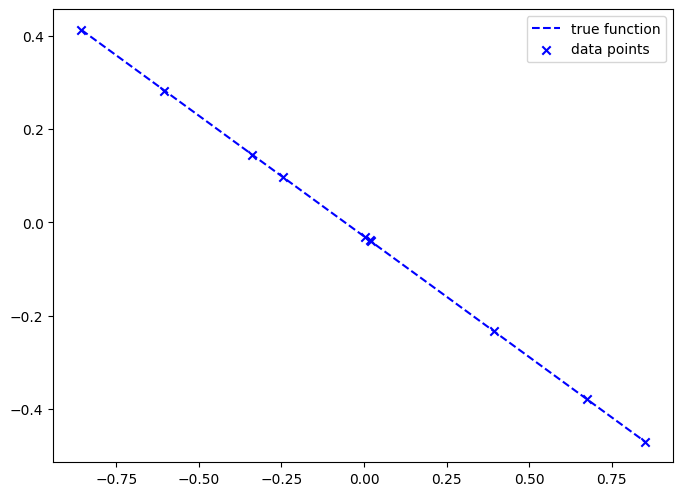

In [7]:
from matplotlib.pyplot import figure


figure(figsize=(8, 6), dpi=100)
plt.plot(x.squeeze(-1), y_true.squeeze(-1), 'b--', label='true function')
plt.scatter(x.squeeze(-1), y_true.squeeze(-1), color='b', marker='x', label='data points')
plt.legend()
plt.show()

### Linear model

Let us define the simplest model: one layer, linear, no activation function. This is equivalent to linear regression.

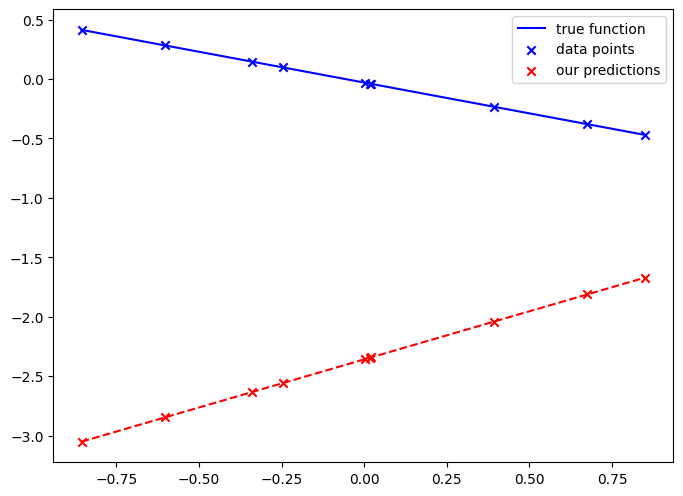

In [8]:
class LinearLayer:
  def __init__(self, input_dim, output_dim):
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.weights = np.random.randn(input_dim, output_dim) * np.sqrt(1. / input_dim) # Not sure why FSDL had np.sqrt(2. / input_dim)
    # It is best to think of the weights as a matrix acting on the input (given as a line vector) by multiplication *on the right*
    self.bias = np.random.randn(output_dim) * np.sqrt(1. / input_dim) # FSDL initializes them to zero: np.zeros(output_dim)
  
  def __call__(self, x):
    return x @ self.weights + self.bias
  # Mind that the first dim of x corresponds to the number of data points.
  # In numpy, when doing matrix multiplication, if either argument is N-dimensional, N > 2, 
  # then it is treated as a stack of matrices residing in the last two indexes.

  def forward(self, x):
    self.x = x
    self.y = self(x)
    return self.y

  def backward(self, previous_grad):
    x = self.x # x has shape (nb_datapoints, input_dim) 
    # previous_grad has shape (nb_datapoints, output_dim)
    self.weights_gradient = x.T @ previous_grad # shape (input_dim, output_dim)
    self.bias_gradient = previous_grad.sum(axis=0) # shape (output_dim,)
    self.x_gradient = previous_grad @ self.weights.T # shape (nb_datapoints, input_dim)
    return self.x_gradient

  def update(self, learning_rate):
    self.weights = self.weights - learning_rate*self.weights_gradient
    self.bias = self.bias - learning_rate*self.bias_gradient
    

linear = LinearLayer(1, 1)
y_pred = linear(x)
figure(figsize=(8, 6), dpi=100)
plt.plot(x.squeeze(-1), y_true.squeeze(-1), 'b-', label='true function')
plt.scatter(x.squeeze(-1), y_true.squeeze(-1), color='b', marker='x', label='data points')
plt.plot(x.squeeze(-1), y_pred.squeeze(-1), 'r--')
plt.scatter(x.squeeze(-1), y_pred.squeeze(-1), color='r', marker='x', label='our predictions')
plt.legend()
plt.show()

Basic metric: MSE


In [9]:
class MSE:
  def __call__(self, y, y_true):
    # y and y true have shape (nb_datapoints, output_dim)
    return ((y - y_true) ** 2).sum(axis=1).mean(axis=0)

  def gradient(self, y, y_true):
    nb_datapoints = y.shape[0]
    return 2. * (y - y_true) / nb_datapoints # shape (nb_datapoints, output_dim)
    # Note: We divide by |nb_datapoints| to not have to do it during backpropagation

  
metric = MSE()
print(f'Our initial loss is {metric(y_pred, y_true)}')

Our initial loss is 5.93146994395591


Let's now create our model:

In [10]:
class LinearModel:
    def __init__(self, layer, metric):
        self.layer = layer
        self.metric = metric

    def __call__(self, x):
        return self.layer(x)

    def forward(self, x):
        self.x = x
        self.y = self.layer.forward(self.x)

    def loss(self, x, y_true):
        return self.metric(self(x), y_true)

    def backward(self, y_true, learning_rate):
        gradient = self.metric.gradient(self.y, y_true) # shape (nb_datapoints, output_dim)
        gradient = self.layer.backward(gradient) # shape (nb_datapoints, input_dim)
        self.layer.update(learning_rate)

Let's try it! Observe that the loss decreases after one forward and backward pass.

In [11]:

def fbar(x):
  return x @ weights_true + bias_true

x = np.random.uniform(-1, 1, (10, 1))
y_true = fbar(x)


linear = LinearLayer(1, 1)
metric = MSE()
model = LinearModel(linear, metric)

print(f"loss = {model.loss(x, y_true)}")

model.forward(x)
model.backward(y_true, 0.1)
print(f"loss = {model.loss(x, y_true)}")

loss = 3.104558211541613
loss = 2.7792590974192715


Let's add some bells and whistles:

In [12]:
# We'll use this to shuffle the dataset (and labels accordingly)
def shuffle_sync(*arrs):
    '''Shuffles arrays of the same length according to a same random permutation'''
    seed = np.random.randint(0, 2**(32 - 1) - 1)
    for arr in arrs:
        rstate = np.random.RandomState(seed)
        rstate.shuffle(arr)

x = np.arange(10)
y = np.arange(10, 20)
print(x,y)
shuffle_sync(x,y)
print(x,y)

[0 1 2 3 4 5 6 7 8 9] [10 11 12 13 14 15 16 17 18 19]
[2 1 9 8 5 4 0 6 3 7] [12 11 19 18 15 14 10 16 13 17]


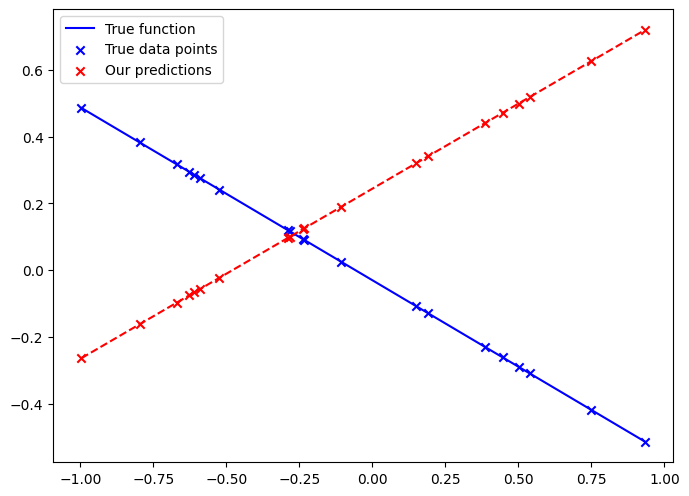

Epoch 5: loss = 1.160000903069298e-07
Epoch 10: loss = 1.297458378309392e-14


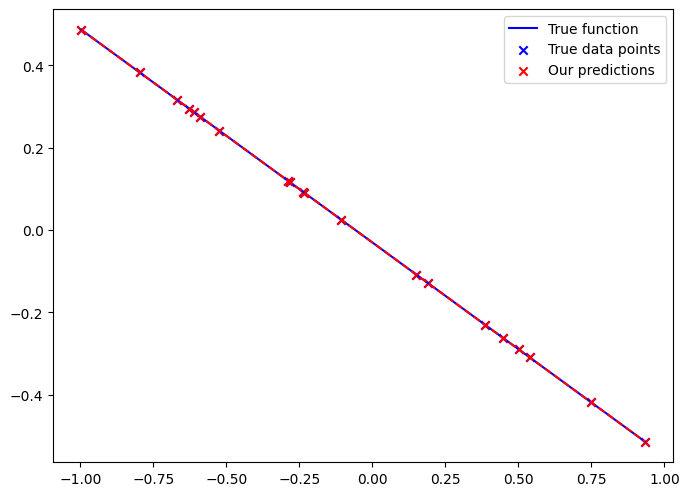

In [13]:
class LinearModel:
    def __init__(self, layer, metric):
        self.layer = layer
        self.metric = metric

    def __call__(self, x):
        return self.layer(x)

    def forward(self, x):
        self.x = x
        self.y = self.layer.forward(x)

    def training_loss(self):
        return self.metric(self(self.x_training), self.y_true_training)

    def backward(self, y_true, learning_rate):
        gradient = self.metric.gradient(self.y, y_true) # shape (nb_datapoints, output_dim)
        gradient = self.layer.backward(gradient) # shape (nb_datapoints, input_dim)
        self.layer.update(learning_rate)

    def set_training_data(self, x_training):
        self.x_training = x_training
        self.nb_datapoints = x_training.shape[0]

    def set_training_labels(self, y_true_training=None, true_function=None):
            assert((y_true_training is None) ^ (true_function is None))
            if true_function:
                y_true_training = true_function(self.x_training)
            self.y_true_training = y_true_training

    def set_training_parameters(self, batch_size=5, learning_rate=0.1):
        self.batch_size = batch_size
        self.learning_rate = learning_rate

    def train(self, nb_epochs):
        x_training = np.copy(self.x_training)
        y_true_training = np.copy(self.y_true_training)

        for epoch in range(1, nb_epochs+1):
            shuffle_sync(x_training, y_true_training)

            k=0
            while k < self.nb_datapoints:
                k_next = min(k+self.batch_size, self.nb_datapoints)
                x_batch = x_training[k:k_next]
                y_true_batch = y_true_training[k:k_next]
                self.forward(x_batch)
                self.backward(y_true_batch, self.learning_rate)
                k = k_next

            if epoch % 5 ==0:
                print(f"Epoch {epoch}: loss = {self.training_loss()}")

    def plot(self): # Only works if (input_dim, output_dim) = (1, 1)
        x = self.x_training
        y_pred = model(self.x_training)
        y_true = self.y_true_training

        figure(figsize=(8, 6), dpi=100)
        plt.plot(x, y_true, 'b-', label='True function')
        plt.scatter(x, y_true, color='b', marker='x', label='True data points')
        plt.plot(x.squeeze(-1), y_pred.squeeze(-1), 'r--')
        plt.scatter(x, y_pred, color='r', marker='x', label='Our predictions')
        plt.legend()
        plt.show()

    def plot3d(self):  # Only works if (input_dim, output_dim) = (2, 1)
        plot3d_sim(x=self.x_training, y_pred = model(self.x_training), y_true = self.y_true_training)

def plot3d_sim(x, y_true, y_pred):
    fig = plt.figure(figsize=(8, 6), dpi=100)
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x[:, 0], x[:, 1], y_true, label='True data points')
    ax.scatter(x[:, 0], x[:, 1], y_pred, label='Our predictions')
    plt.legend()
    plt.show()



def fbar(x):
    return x @ weights_true + bias_true

x = np.random.uniform(-1, 1, (20, 1))
x.sort(axis=0)

linear = LinearLayer(1, 1)
metric = MSE()
model = LinearModel(linear, metric)
model.set_training_data(x)
model.set_training_labels(true_function=fbar)
model.set_training_parameters(batch_size=5, learning_rate=0.5)


model.plot()
model.train(10)
model.plot()

Let's try to approximate a non-linear function:

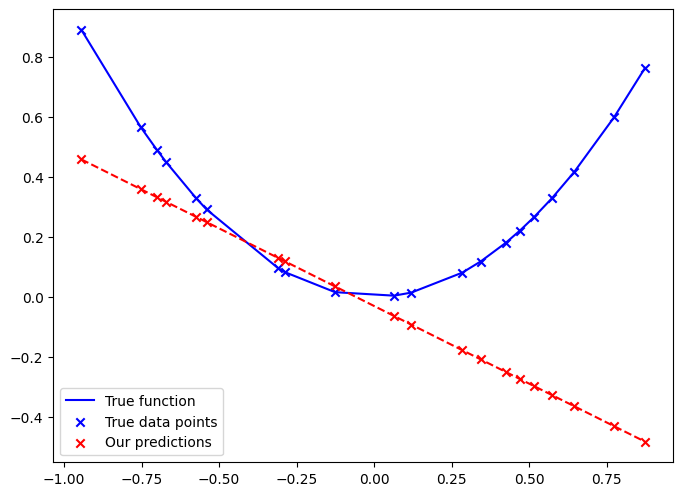

Epoch 5: loss = 0.06500320056587058
Epoch 10: loss = 0.06095713655750803
Epoch 15: loss = 0.0607575196358995
Epoch 20: loss = 0.06069991858888287


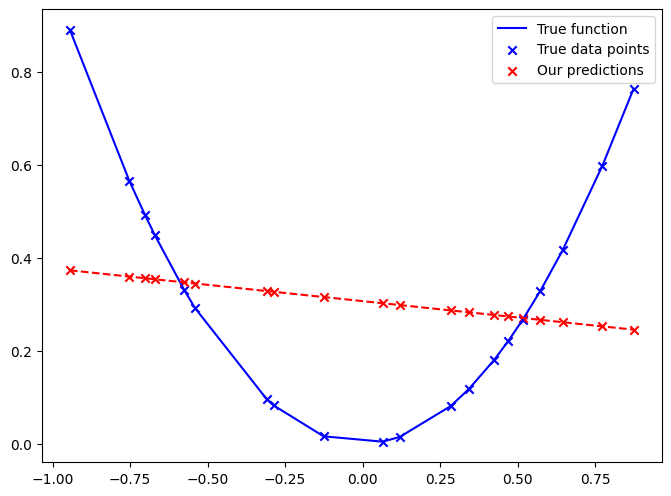

In [14]:
def fbar(x):
    return x ** 2

x = np.random.uniform(-1, 1, (20, 1))
x.sort(axis=0)

model.set_training_data(x)
model.set_training_labels(true_function=fbar)
model.set_training_parameters(learning_rate=0.1)


model.plot()
model.train(20)
model.plot()

### 2-dimensional inputs work too

(100, 2)
(2, 1)


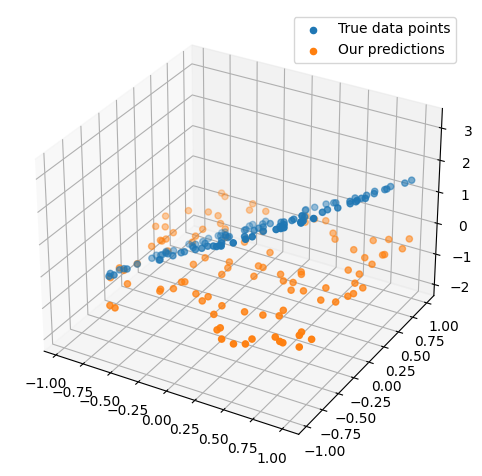

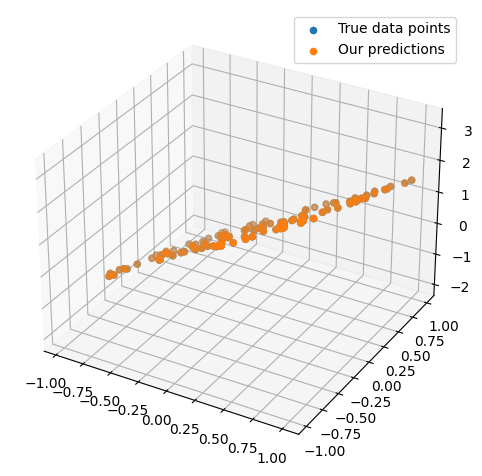

In [15]:
nb_datapoints = 100
input_dim = 2
output_dim = 1
x = np.random.uniform(-1, 1, (nb_datapoints, input_dim))

weights_true = np.array([[2, -1], ]).T
bias_true = np.array([0.5])

print(x.shape)
print(weights_true.shape)

def fbar(x):
  return x @ weights_true + bias_true

y_true = fbar(x)

linear = LinearLayer(2, 1)
metric = MSE()
model = LinearModel(linear, metric)
model.set_training_data(x)
model.set_training_labels(true_function=fbar)
model.set_training_parameters(batch_size=5, learning_rate=0.5)

model.plot3d()
model.train(3)
model.plot3d()

(1000, 1)


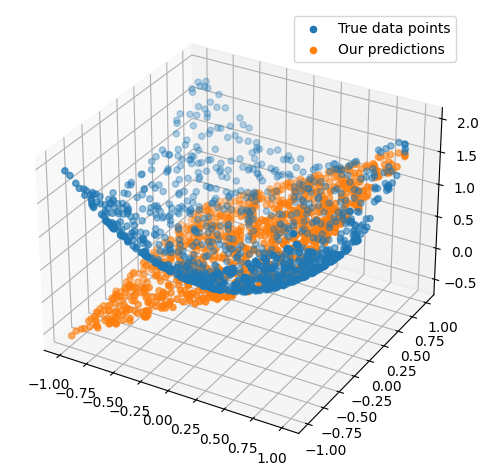

Epoch 5: loss = 0.3392714716828646
Epoch 10: loss = 0.24360925576740006


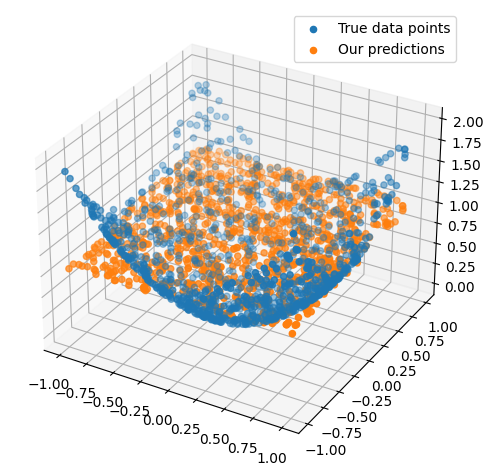

In [16]:
def fbar(x):
  return (x**2).sum(axis=1)[..., None]

nb_datapoints = 1000
input_dim = 2
output_dim = 1
x = np.random.uniform(-1, 1, (nb_datapoints, input_dim))

y_true = fbar(x)
print(y_true.shape)

linear = LinearLayer(2, 1)
metric = MSE()
model = LinearModel(linear, metric)
model.set_training_data(x)
model.set_training_labels(true_function=fbar)
model.set_training_parameters(batch_size=5, learning_rate=0.5)


model.plot3d()
model.train(10)
model.plot3d()

### Add non-linearity: ReLU

In [17]:
class ReluLayer:  
  def __call__(self, x):
    return np.clip(x, 0, None)

  def forward(self, x):
    self.x = x
    self.y = self(x)
    return self.y

  def backward(self, previous_grad):
    self.gradient = (self.x > 0) * previous_grad
    return self.gradient

  def update(self, learning_rate):
    return




f = ReluLayer()
x1 = np.random.uniform(-1, 1, (3, 2))
print(x1)
print(f(x1))

[[-0.16769253  0.08037316]
 [ 0.74882986 -0.85159101]
 [ 0.79888254  0.12569012]]
[[0.         0.08037316]
 [0.74882986 0.        ]
 [0.79888254 0.12569012]]


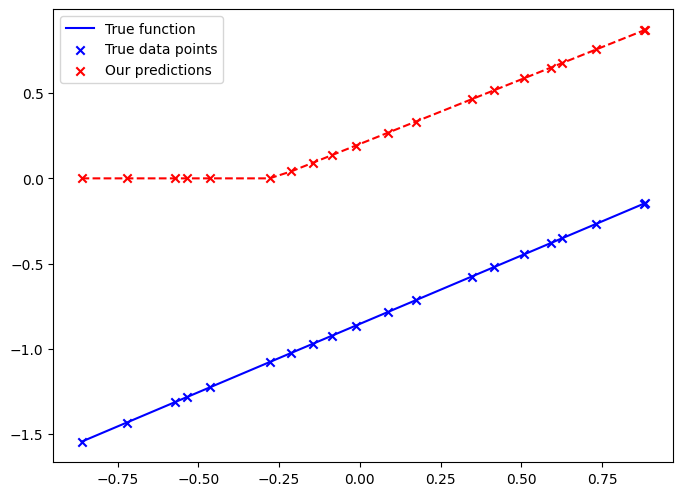

Epoch 5: loss = 0.8181739894160973
Epoch 10: loss = 0.8173329002374287
Epoch 15: loss = 0.8173329002374287
Epoch 20: loss = 0.8173329002374287


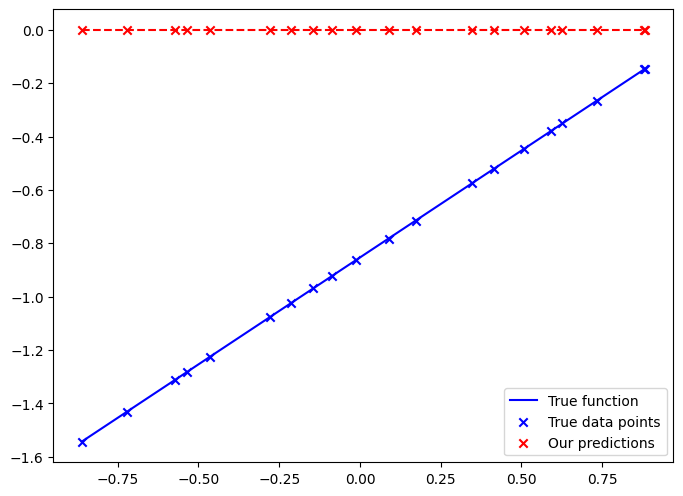

In [18]:
class Model:
    def __init__(self, *layers, metric):
        self.layers = layers
        self.metric = metric

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def forward(self, x):
        for layer in self.layers:
            y = layer.forward(x)
            x = y
        self.y = y
        return y

    def training_loss(self):
        return self.metric(self(self.x_training), self.y_true_training)

    def backward(self, y_true, learning_rate):
        gradient = self.metric.gradient(self.y, y_true)
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)
            layer.update(learning_rate)

    def set_training_data(self, x_training):
        self.x_training = x_training
        self.nb_datapoints = x_training.shape[0]

    def set_training_labels(self, y_true_training=None, true_function=None):
            assert((y_true_training is None) ^ (true_function is None))
            if true_function:
                y_true_training = true_function(self.x_training)
            self.y_true_training = y_true_training

    def set_training_parameters(self, batch_size=5, learning_rate=0.1):
        self.batch_size = batch_size
        self.learning_rate = learning_rate

    def train(self, nb_epochs):
        x_training = np.copy(self.x_training)
        y_true_training = np.copy(self.y_true_training)

        for epoch in range(1, nb_epochs+1):
            shuffle_sync(x_training, y_true_training)

            k=0
            while k < self.nb_datapoints:
                k_next = min(k+self.batch_size, self.nb_datapoints)
                x_batch = x_training[k:k_next]
                y_true_batch = y_true_training[k:k_next]
                self.forward(x_batch)
                self.backward(y_true_batch, self.learning_rate)
                k = k_next

            if epoch % 5 ==0:
                print(f"Epoch {epoch}: loss = {self.training_loss()}")

    def plot(self): # Only works if (input_dim, output_dim) = (1, 1)
        x = self.x_training
        y_pred = model(self.x_training)
        y_true = self.y_true_training

        figure(figsize=(8, 6), dpi=100)
        plt.plot(x, y_true, 'b-', label='True function')
        plt.scatter(x, y_true, color='b', marker='x', label='True data points')
        plt.plot(x.squeeze(-1), y_pred.squeeze(-1), 'r--')
        plt.scatter(x, y_pred, color='r', marker='x', label='Our predictions')
        plt.legend()
        plt.show()

    def plot3d(self):  # Only works if (input_dim, output_dim) = (2, 1)
        plot3d_sim(x = self.x_training, y_pred = model(self.x_training), y_true = self.y_true_training)


nb_datapoints = 20
input_dim = 1
output_dim = 1
weights_true = np.random.uniform(-1, 1, (input_dim, output_dim))
bias_true = np.random.uniform(-1, 1, (output_dim,))

def fbar(x):
    return x @ weights_true + bias_true

x = np.random.uniform(-1, 1, (nb_datapoints, input_dim))
x.sort(axis=0)

lin = LinearLayer(1, 1)
rel = ReluLayer()
met = MSE()
model = Model(lin, rel, metric=met)
model.set_training_data(x)
model.set_training_labels(true_function=fbar)
model.set_training_parameters(batch_size=5, learning_rate=0.1)


model.plot()
model.train(20)
model.plot()

Oops! Of course our model cannot produce negative predictions. Like add a second linear layer:

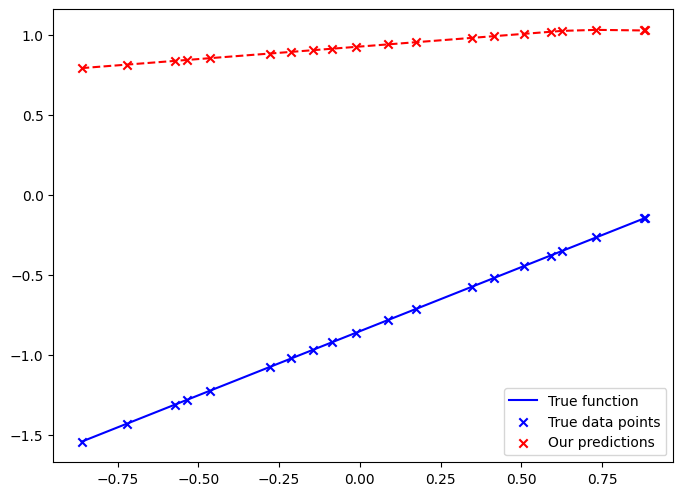

Epoch 5: loss = 0.08130701432214313
Epoch 10: loss = 0.007539588371753185
Epoch 15: loss = 0.000996515569207468
Epoch 20: loss = 0.0003212373593920395
Epoch 25: loss = 0.00014264977106434872
Epoch 30: loss = 6.235478204763213e-05
Epoch 35: loss = 2.889980716925688e-05
Epoch 40: loss = 1.3624859748179537e-05
Epoch 45: loss = 6.2470353620328825e-06
Epoch 50: loss = 4.309919288198726e-06


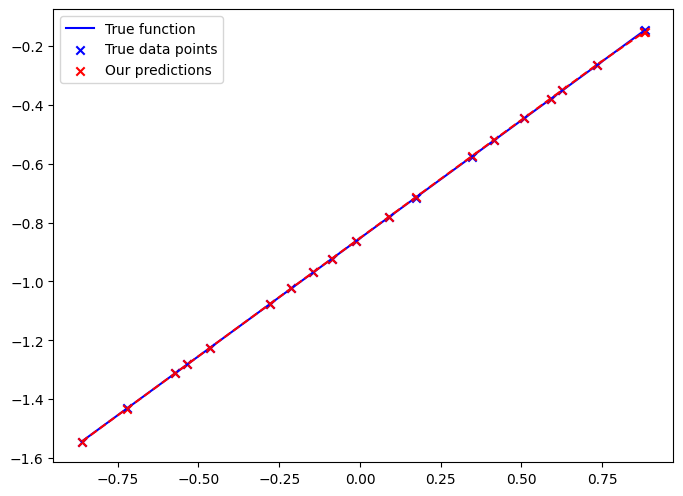

In [19]:
lin1 = LinearLayer(1, 10)
rel1 = ReluLayer()
lin2 = LinearLayer(10, 1)
met = MSE()
model = Model(lin1, rel1, lin2, metric=met)
model.set_training_data(x)
model.set_training_labels(true_function=fbar)
model.set_training_parameters(batch_size=5, learning_rate=0.1)


model.plot()
model.train(50)
model.plot()

What about approximating a non-linear function?

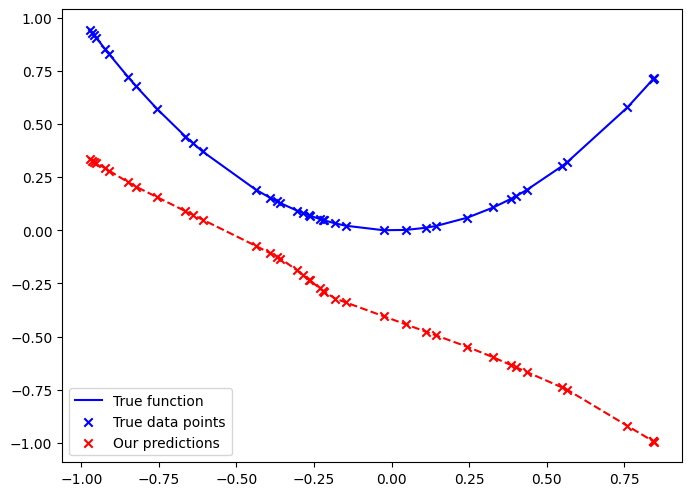

Epoch 5: loss = 0.032776050683006146
Epoch 10: loss = 0.006206075981750769
Epoch 15: loss = 0.009497614110710784
Epoch 20: loss = 0.0072226213749577
Epoch 25: loss = 0.001920658471401608
Epoch 30: loss = 0.0008416415866688903
Epoch 35: loss = 0.0005309599259250237
Epoch 40: loss = 0.0009342924994739986
Epoch 45: loss = 0.001412800978694294
Epoch 50: loss = 0.00044790695983358347
Epoch 55: loss = 0.000855288621171912
Epoch 60: loss = 0.0018650012998877967
Epoch 65: loss = 0.0002621983733398736
Epoch 70: loss = 0.00042378042141969304
Epoch 75: loss = 0.0002712485276853111
Epoch 80: loss = 0.0002331685133250517
Epoch 85: loss = 0.0010187766752879994
Epoch 90: loss = 0.0002660746978377576
Epoch 95: loss = 0.00021572178414608622
Epoch 100: loss = 0.00029269730395680256


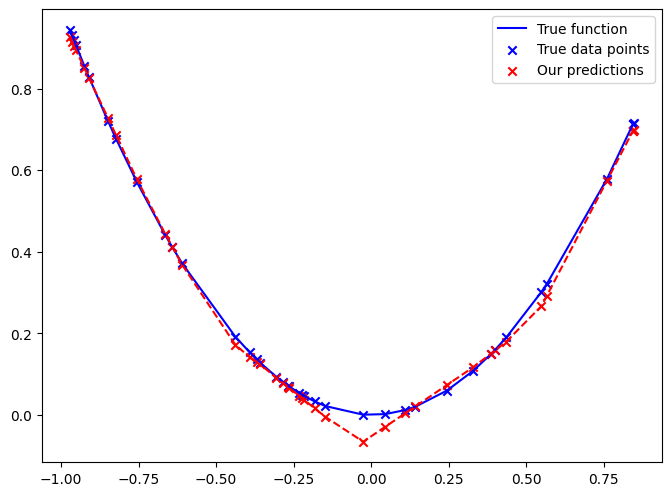

In [20]:
nb_datapoints = 40
input_dim = 1
output_dim = 1

def fbar(x):
    return x**2

x = np.random.uniform(-1, 1, (nb_datapoints, input_dim))
x.sort(axis=0)

nb_hidden = 20
lin1 = LinearLayer(1, nb_hidden)
rel1 = ReluLayer()
lin2 = LinearLayer(nb_hidden, 1)
met = MSE()
model = Model(lin1, rel1, lin2, metric=met)
model.set_training_data(x)
model.set_training_labels(true_function=fbar)
model.set_training_parameters(batch_size=5, learning_rate=0.1)


model.plot()
model.train(100)
model.plot()

Notice how it's very sensitive to the hyperparameters! For instance, a learning rate >0.2 won't work.

What about 2D?

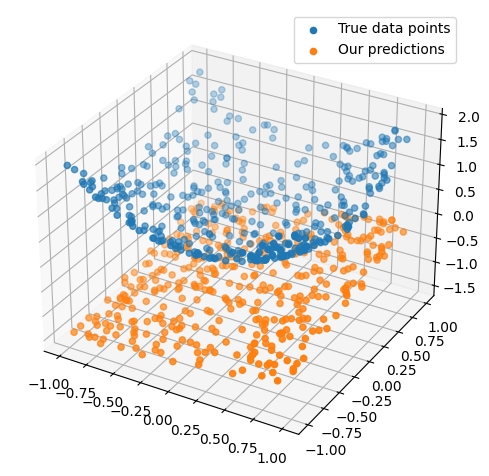

Epoch 5: loss = 0.008209568052723866
Epoch 10: loss = 0.006327078138137929
Epoch 15: loss = 0.0050660663223094995
Epoch 20: loss = 0.007048140282803408
Epoch 25: loss = 0.0031560572379744174
Epoch 30: loss = 0.0023702515935710737
Epoch 35: loss = 0.00190846405661652
Epoch 40: loss = 0.0016434007442133337
Epoch 45: loss = 0.0022445761835643446
Epoch 50: loss = 0.0011288003423951373


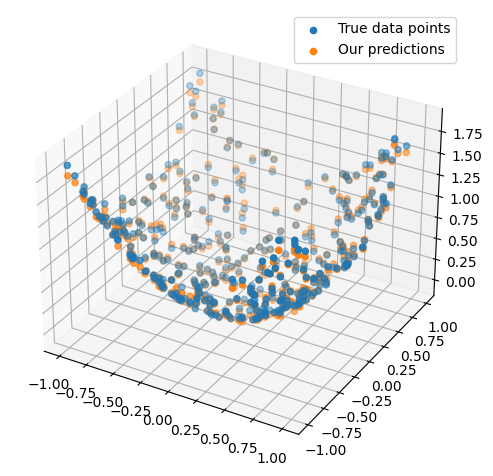

In [21]:
nb_datapoints = 400
input_dim = 2
output_dim = 1

def fbar(x):
    return (x**2).sum(axis=1)[..., None]

x = np.random.uniform(-1, 1, (nb_datapoints, input_dim))



nb_hidden = 20
lin1 = LinearLayer(input_dim, nb_hidden)
rel1 = ReluLayer()
lin2 = LinearLayer(nb_hidden, 1)
met = MSE()
model = Model(lin1, rel1, lin2, metric=met)
model.set_training_data(x)
model.set_training_labels(true_function=fbar)
model.set_training_parameters(batch_size=5, learning_rate=0.1)


model.plot3d()
model.train(50)
model.plot3d()

### Same thing, in PyTorch

In [22]:
import torch
import torch.nn as nn


class TorchModel(nn.Module):
  def __init__(self, input_dim, nb_hidden):
    super().__init__()
    self.lin1 = nn.Linear(input_dim, nb_hidden)
    self.relu = nn.ReLU()
    self.lin2 = nn.Linear(nb_hidden, 1)
  
  def forward(self, x):
    x = self.lin1(x)
    x = self.relu(x)
    x = self.lin2(x)
    return x

input_dim = 2
nb_datapoints = 400
nb_hidden = 20

x = np.random.uniform(-1, 1, (nb_datapoints, input_dim))
y_true = (x**2).sum(axis=1)[..., None]

loss = nn.MSELoss()
model = TorchModel(input_dim, nb_hidden)

x_tensor = torch.tensor(x).float()
y_true_tensor = torch.tensor(y_true).float()
y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)

tensor(0.4682, grad_fn=<MseLossBackward0>)


In [23]:
# Test just one forward and backward step
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

optimizer.zero_grad()
y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)
loss_gradient = loss_value.backward() # I think this stores the gradient in y_pred
optimizer.step()

y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)

tensor(0.4682, grad_fn=<MseLossBackward0>)
tensor(0.2080, grad_fn=<MseLossBackward0>)


Epoch 0: loss = 0.2079927623271942
Epoch 5: loss = 0.1783006489276886
Epoch 10: loss = 0.1471657156944275
Epoch 15: loss = 0.12945711612701416
Epoch 20: loss = 0.10947477072477341
Epoch 25: loss = 0.08898332715034485
Epoch 30: loss = 0.07064543664455414
Epoch 35: loss = 0.05479629337787628
Epoch 40: loss = 0.04145612567663193
Epoch 45: loss = 0.030416879802942276


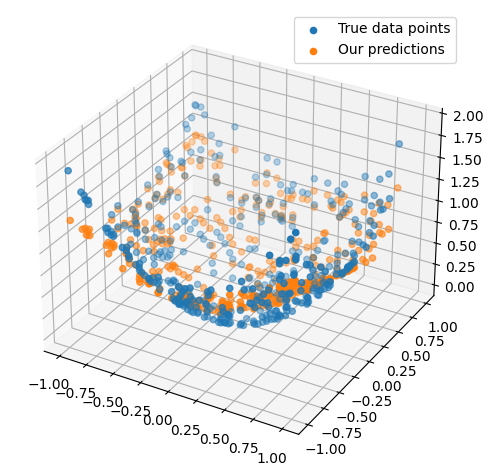

In [24]:
from typing import Callable


# Now we run the training loop

def torch_fit(x: np.ndarray, y: np.ndarray, model: Callable, loss: Callable, lr: float, num_epochs: int):
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)
  for epoch in range(num_epochs):
    optimizer.zero_grad()
    y_pred_tensor = model(x_tensor)
    loss_value = loss(y_pred_tensor, y_true_tensor)
    
    if epoch % 5 ==0:
      print(f"Epoch {epoch}: loss = {loss_value.item()}")
    loss_value.backward()
    optimizer.step()

torch_fit(x_tensor, y_true_tensor, model=model, loss=loss, lr=0.5, num_epochs=50)

plot3d_sim(x, y_true, model(x_tensor).detach())

### Same thing, in Tensorflow/Keras

2022-02-01 17:32:18.430630: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-01 17:32:18.430657: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-02-01 17:32:20.701974: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-01 17:32:20.702973: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-01 17:32:20.703068: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.s

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2)]               0         
                                                                 
 hidden (Dense)              (None, 20)                60        
                                                                 
 regression (Dense)          (None, 1)                 21        
                                                                 
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
13/13 [==============================] - 1s 2ms/step - loss: 0.1894
Epoch 2/50
13/13 [==============================] - 0s 2ms/step - loss: 0.1125
Epoch 3/50
13/13 [==============================] - 0s 2ms/step - loss: 0.0955
Epoch 4/50
13/13 [==============================] - 0s 2ms/step - loss: 0.0811
Epoch 5/

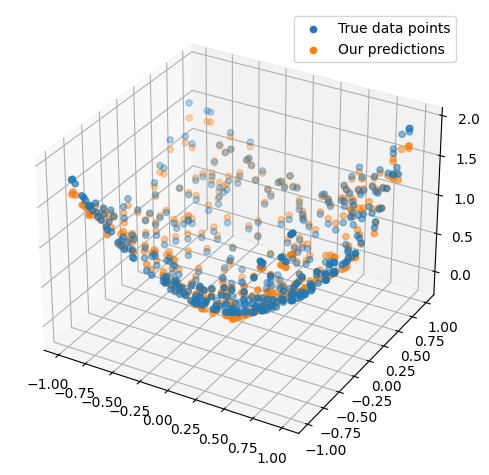

In [25]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers


input_dim = 2
nb_hidden = 20

inputs = keras.Input(shape=(input_dim,), name='input')
hidden = layers.Dense(nb_hidden, activation='relu', name='hidden')(inputs)
outputs = layers.Dense(1, name='regression')(hidden)

model = keras.Model(inputs=inputs, outputs=outputs)
print(model.summary())
model.compile(loss='mse', optimizer=optimizers.SGD(0.1))


nb_datapoints = 400
x = np.random.uniform(-1, 1, (nb_datapoints, input_dim))
y_true = (x**2).sum(axis=1)[..., None]


model.fit(x, y_true, epochs=50)
y_pred = model.predict(x)

plot3d_sim(x, y_true, model(x))